In [145]:
import json
import requests
import pandas as pd
import time
import io

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [115]:
# Remplace 'XXXXXXXXXX' par ton Application ID que tu obtiens sur le portail API de Météo-France
APPLICATION_ID = 'SkM3T2Zta2c0V3A1VktrUkFtY0Y1TFZkazBrYTpzalloZm11VHhXbmR5TWlvTlZmRUV1WEFYZ1Fh'

# URL pour obtenir le token d'accès
TOKEN_URL = "https://portail-api.meteofrance.fr/token"

In [116]:
class Client(object):
    def __init__(self):
        self.session = requests.Session()

    def request(self, method, url, **kwargs):
        # Vérifie si le token est présent dans l'en-tête, sinon obtient un nouveau token
        if 'Authorization' not in self.session.headers:
            self.obtain_token()

        # Essaye de faire la requête
        response = self.session.request(method, url, **kwargs)
        if self.token_has_expired(response):
            # Si le token a expiré, en obtient un nouveau
            self.obtain_token()
            # Refaire la requête avec le nouveau token
            response = self.session.request(method, url, **kwargs)

        return response

    def token_has_expired(self, response):
        # Vérifie si le token a expiré (erreur 401 et token JWT invalide)
        status = response.status_code
        content_type = response.headers.get('Content-Type', '')
        if status == 401 and 'application/json' in content_type:
            repJson = json.loads(response.text)
            if 'Invalid JWT token' in repJson.get('description', ''):
                return True
        return False

    def obtain_token(self):
        # Obtenir un nouveau token JWT
        data = {'grant_type': 'client_credentials'}
        headers = {'Authorization': 'Basic ' + APPLICATION_ID}
        access_token_response = requests.post(TOKEN_URL, data=data, headers=headers)

        # Gestion des erreurs possibles lors de la requête
        if access_token_response.status_code != 200:
            raise Exception("Erreur lors de l'obtention du token : ", access_token_response.text)

        token = access_token_response.json()['access_token']

        # Met à jour la session avec le nouveau token
        self.session.headers.update({'Authorization': 'Bearer %s' % token})


In [130]:
# Crée une instance de la classe client
client = Client()

# Exemple de requête : obtenir des informations via l'API AROME
client.session.headers.update({'Accept': 'application/json'})

In [118]:
# URL de base pour l'API
base_url = 'https://public-api.meteofrance.fr/public/DPClim/v1/liste-stations/quotidienne?id-departement='

# Liste pour stocker les DataFrames
all_dfs = []

# Boucle pour récupérer les données de chaque département (de 1 à 95)
for dep in range(1, 96):
    
    # Construire l'URL pour chaque département
    url = f'{base_url}{dep}'
    # Faire la requête
    response = client.request('GET', url)
    
    # Vérifier le statut de la requête
    if response.status_code == 200:
        print(f"Ok pour le département {dep}")
        # Charger les données en JSON
        data = json.loads(response.text)
        
        # Convertir les données en DataFrame
        df = pd.DataFrame(data)
        
        # Ajouter le DataFrame à la liste
        all_dfs.append(df)
    else:
        print(f"Erreur pour le département {dep}: {response.status_code}")
    
    # Introduire un délai de 1,2 seconde entre les requêtes
    time.sleep(1.2)

# Concaténer tous les DataFrames en un seul
final_df = pd.concat(all_dfs, ignore_index=True)

# Afficher le nombre total de lignes et colonnes
print(final_df.shape)
# Afficher les premières lignes du DataFrame final
print(final_df.head())

Ok pour le département 1
Ok pour le département 2
Ok pour le département 3
Ok pour le département 4
Ok pour le département 5
Ok pour le département 6
Ok pour le département 7
Ok pour le département 8
Ok pour le département 9
Ok pour le département 10
Ok pour le département 11
Ok pour le département 12
Ok pour le département 13
Ok pour le département 14
Ok pour le département 15
Ok pour le département 16
Ok pour le département 17
Ok pour le département 18
Ok pour le département 19
Ok pour le département 20
Ok pour le département 21
Ok pour le département 22
Ok pour le département 23
Ok pour le département 24
Ok pour le département 25
Ok pour le département 26
Ok pour le département 27
Ok pour le département 28
Ok pour le département 29
Ok pour le département 30
Ok pour le département 31
Ok pour le département 32
Ok pour le département 33
Ok pour le département 34
Ok pour le département 35
Ok pour le département 36
Ok pour le département 37
Ok pour le département 38
Ok pour le départemen

In [119]:
# Définir les limites géographiques approximatives de la France métropolitaine
min_lon, max_lon = -5.5, 10  # Limites de longitude
min_lat, max_lat = 41, 51    # Limites de latitude

# Filtrer les points qui sont en dehors des limites de la France
final_df_filtered = final_df[
    (final_df['lon'] >= min_lon) & (final_df['lon'] <= max_lon) &
    (final_df['lat'] >= min_lat) & (final_df['lat'] <= max_lat)
]

In [120]:
# Conversion des points en objets géométriques
geometry = [Point(xy) for xy in zip(final_df_filtered['lon'], final_df_filtered['lat'])]
gdf = gpd.GeoDataFrame(final_df_filtered, geometry=geometry)

# Configurer le système de coordonnées EPSG 4326 (WGS84)
gdf = gdf.set_crs(epsg=4326)

# Transformer le système de coordonnées pour le fond de carte (Web Mercator, EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

In [123]:
# Filtrer le DataFrame pour les lignes où posteOuvert est True
gdf = gdf[(gdf['posteOuvert'] == True)][['id', 'lon', 'lat', 'geometry']]

In [126]:
print(gdf.shape)
gdf.head()

(2683, 4)


,id,lon,lat,geometry
3,01014002,5.669000,46.278167,POINT (631070.193 5825038.283)
7,01027003,5.106667,45.833000,POINT (568471.570 5753627.622)
14,01034004,5.688000,45.769333,POINT (633185.264 5743461.410)
22,01064001,5.487167,45.777167,POINT (610828.636 5744711.700)
24,01071001,6.080333,46.310333,POINT (676859.573 5830220.535)


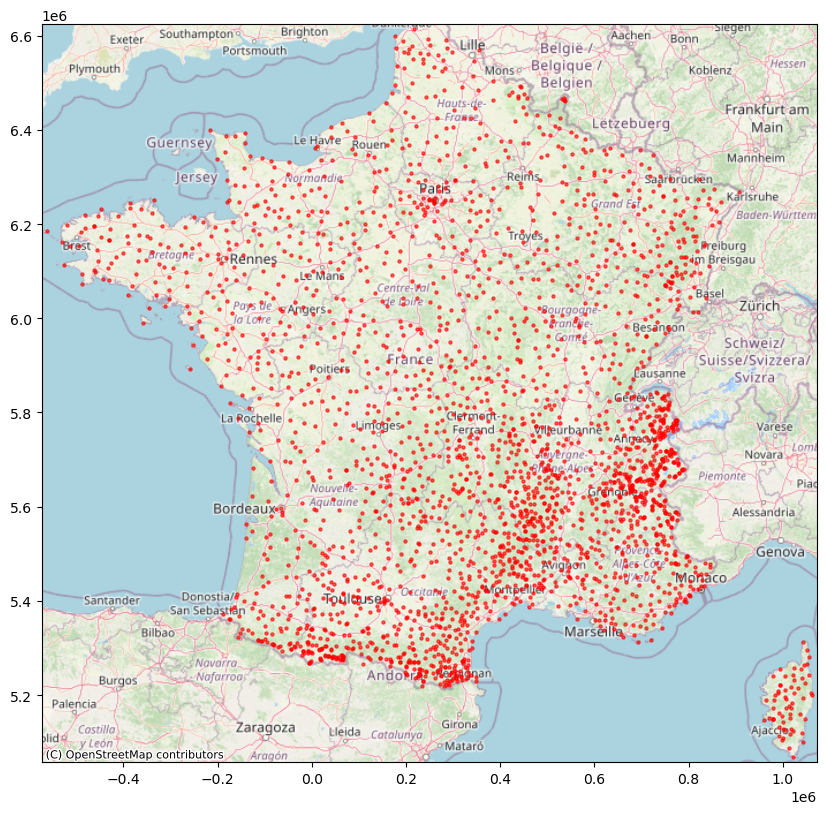

In [124]:
# Création de la figure
fig, ax = plt.subplots(figsize=(10, 10))

# Ajouter les points
gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.6)

# Utiliser une autre source de tuiles, comme OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajuster les limites de la carte selon les bornes des points
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin - 10000, xmax + 10000)  # Ajuster légèrement autour des bornes
ax.set_ylim(ymin - 10000, ymax + 10000)

# Afficher la carte
plt.show()

In [149]:
# Fonction pour envoyer les commandes et stocker les identifiants
def send_station_orders(station_ids, client):
    commande_ids = []
    
    for station_id in station_ids:
        url = f'https://public-api.meteofrance.fr/public/DPClim/v1/commande-station/quotidienne?id-station={station_id}&date-deb-periode=2023-01-01T0%3A00%3A00Z&date-fin-periode=2023-12-31T23%3A00%3A00Z'
        response = client.request('GET', url)
        
        if response.status_code == 202:
            # Extraire l'ID de commande
            commande_id = json.loads(response.text)['elaboreProduitAvecDemandeResponse']['return']
            print(f"Commande pour la station {station_id}: {commande_id}")
            commande_ids.append(commande_id)
        else:
            print(f"Erreur lors de la commande pour la station {station_id}. Statut : {response.status_code}")
        
        # Pause pour respecter la limite des 50 requêtes/minute
        time.sleep(1.2)
    
    return commande_ids

In [150]:
# Fonction pour récupérer les données avec les identifiants de commande
def fetch_station_data_with_orders(commande_ids, client):
    all_data = []
    
    for commande_id in commande_ids:
        url_data = f'https://public-api.meteofrance.fr/public/DPClim/v1/commande/fichier?id-cmde={commande_id}'
        response_data = client.request('GET', url_data)
        
        if response_data.status_code == 201:
            # Charger la réponse comme un CSV
            data_csv = response_data.text
            
            # Utiliser pandas pour lire le texte CSV
            data = pd.read_csv(io.StringIO(data_csv), sep=';', header=0)
            all_data.append(data)
        else:
            print(f"Erreur lors de la récupération des données pour la commande {commande_id}. Statut : {response_data.status_code}")
        
        # Pause pour respecter la limite des 50 requêtes/minute
        time.sleep(1.2)
    
    # Fusionner tous les DataFrames en un seul
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide s'il n'y a pas de données

In [153]:
# Étape 1 : Envoyer toutes les commandes pour chaque station
commande_ids = send_station_orders(gdf["id"][:10], client)

Commande pour la station 01014002: 783890201671
Commande pour la station 01027003: 783890203072
Commande pour la station 01034004: 783890204431
Commande pour la station 01064001: 783890205782
Commande pour la station 01071001: 783890207126
Commande pour la station 01072001: 783890208469
Commande pour la station 01089001: 783890209801
Commande pour la station 01143002: 783890211133
Commande pour la station 01185006: 783890212537
Commande pour la station 01200002: 783890213911


In [158]:
df_results["ETPMON"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3645    NaN
3646    NaN
3647    NaN
3648    NaN
3649    NaN
Name: ETPMON, Length: 3650, dtype: object

In [161]:
df_results["POSTE"].value_counts()

POSTE
1014002    365
1027003    365
1034004    365
1064001    365
1071001    365
1072001    365
1089001    365
1143002    365
1185006    365
1200002    365
Name: count, dtype: int64

In [154]:
# Étape 2 : Récupérer les données avec les identifiants de commande
df_results = fetch_station_data_with_orders(commande_ids, client)

# Afficher les résultats
print(df_results.head())

     POSTE      DATE    RR  DRR    TN     HTN    TX     HTX    TM   TMNX  ...  \
0  1014002  20230101   0,0  NaN  11,6   115.0  17,7  1123.0  14,3  14,65  ...   
1  1014002  20230102  11,0  NaN   8,6  1746.0  14,3   846.0  11,5  11,45  ...   
2  1014002  20230103   0,4  NaN   1,8  1733.0  10,8  1303.0   6,2   6,30  ...   
3  1014002  20230104  10,6  NaN   1,0   712.0   8,6  1401.0   5,1   4,80  ...   
4  1014002  20230105   3,4  NaN   6,9  1816.0  10,8  1331.0   8,7   8,85  ...   

  BRUME ECLAIR  ETPMON ETPGRILLE  UV TMERMAX TMERMIN HNEIGEF NEIGETOTX  \
0   NaN    NaN     NaN       3,1 NaN     NaN     NaN     NaN       0.0   
1   NaN    NaN     NaN       1,9 NaN     NaN     NaN     NaN       0.0   
2   NaN    NaN     NaN       0,2 NaN     NaN     NaN     NaN       0.0   
3   NaN    NaN     NaN       0,0 NaN     NaN     NaN     NaN       0.0   
4   NaN    NaN     NaN       0,1 NaN     NaN     NaN     NaN       0.0   

   NEIGETOT06  
0         0.0  
1         0.0  
2         0.0  
3   

In [148]:
# Liste pour stocker les résultats
results = []

# Boucle pour traiter chaque station
for index, row in gdf.iterrows():
    station_id = row['id']
    
    # Récupérer les données pour la station
    data = fetch_station_data(station_id, client)
    print(data)
    if data:
        # Ajouter les données à la liste des résultats
        results.append(data)
    else:
        print("Erreur, aucune data")

Commande pour la station 01014002: 783889950321
Erreur lors de la récupération des données pour la station 01014002. Statut : 204
None
Erreur, aucune data
Commande pour la station 01027003: 783889951720
       POSTE      DATE  RR  DRR    TN     HTN    TX     HTX    TM   TMNX  ...  \
0    1027003  20230101 NaN  NaN  12,5   734.0  17,8  1215.0  14,9  15,15  ...   
1    1027003  20230102 NaN  NaN  10,1  1759.0  15,2  1150.0  12,2  12,65  ...   
2    1027003  20230103 NaN  NaN   5,4  1756.0  12,2  1232.0   7,1   8,80  ...   
3    1027003  20230104 NaN  NaN  -0,1  2352.0   9,2  1412.0   6,1   4,55  ...   
4    1027003  20230105 NaN  NaN   7,3  1905.0  10,9  1420.0   9,5   9,10  ...   
..       ...       ...  ..  ...   ...     ...   ...     ...   ...    ...  ...   
360  1027003  20231227 NaN  NaN  -2,9   818.0  13,8  1421.0   4,7   5,45  ...   
361  1027003  20231228 NaN  NaN   2,8   451.0  13,3  1209.0   9,6   8,05  ...   
362  1027003  20231229 NaN  NaN   5,1   722.0  13,0  1436.0   9,0   

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results)

In [ ]:
df_results.head()

In [110]:
# Remplace l'URL par l'endpoint correct pour les données AROME ou autres APIs auxquelles tu as accès
url = 'https://public-api.meteofrance.fr/public/DPClim/v1/commande-station/quotidienne?id-station=01034004&date-deb-periode=2023-01-01T0%3A00%3A00Z&date-fin-periode=2023-12-31T23%3A00%3A00Z'

response = client.request('GET', url)

# Affiche le statut de la requête
print(f"Statut : {response.status_code}")
print(response.text)

Statut : 202
{"elaboreProduitAvecDemandeResponse": {"return": "783872935590"}}


In [140]:
# Remplace l'URL par l'endpoint correct pour les données AROME ou autres APIs auxquelles tu as accès
url = 'https://public-api.meteofrance.fr/public/DPClim/v1/commande/fichier?id-cmde=783889719470'

response = client.request('GET', url)

# Affiche le statut de la requête
print(f"Statut : {response.status_code}")
print(response.text)

Statut : 410
production déjà livrée
